In [1]:
from torchinfo import summary
# from util_plots import *
from utils.util_plots2 import *
from utils.util_dataload import *
from utils.util_train import *
from utils.util_dset import *

import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import time
from datetime import datetime
import random
from tqdm.auto import tqdm
import os
import requests
import zipfile

from pathlib import Path
import pathlib


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print("torch version: ", torch.__version__)



cuda
torch version:  1.13.1


In [4]:
# Setup path to data folder
data_path = Path("ds/DARK/aug_49_mlo_CROP/")
image_path = data_path 

train_dir = image_path / "train"
test_dir = image_path / "test"

file_labels = []
for name in os.listdir(train_dir):
    file_labels.append(name)

print("Train directory: ",train_dir)
print("Test directory: ",test_dir)
print("Labels: ",file_labels)

Train directory:  ds\DARK\aug_49_mlo_CROP\train
Test directory:  ds\DARK\aug_49_mlo_CROP\test
Labels:  ['0', '1']


In [6]:
train_img_len = []
test_img_len = []

for file_name in [train_dir, test_dir]:
    for label_index in range(len(file_labels)):
        label_path = file_name/ file_labels[label_index]
        lst = os.listdir(label_path)
        number_of_imgs = len(lst)
        print("Path:", label_path, " |  # of images: ", number_of_imgs)

        if file_name == train_dir:
            train_img_len.append(number_of_imgs)
        if file_name == test_dir:
            test_img_len.append(number_of_imgs)
    print("---")


print("Train size:",sum(train_img_len))
print("Test size:",sum(test_img_len))

bar_colors = ['#7eb54e','red']

dataset_all_len = [sum(x) for x in zip(train_img_len, test_img_len)]

# print(train_img_len)
# print(test_img_len)
# print(dataset_all_len)

# single_bar_plot_dataset_53(file_labels, train_img_len, "Train Set Sample Dist", "Labels", "Number of Samples", bar_color=bar_colors )
# single_bar_plot_dataset_53(file_labels, test_img_len, "Test Set Sample Dist", "Labels", "Number of Samples", bar_color=bar_colors )
# single_bar_plot_dataset_53(file_labels, dataset_all_len, "Dataset Sample Dist", "Labels", "Number of Samples", bar_color=bar_colors )


Path: ds\DARK\aug_49_mlo_CROP\train\0  |  # of images:  4700
Path: ds\DARK\aug_49_mlo_CROP\train\1  |  # of images:  4700
---
Path: ds\DARK\aug_49_mlo_CROP\test\0  |  # of images:  2089
Path: ds\DARK\aug_49_mlo_CROP\test\1  |  # of images:  59
---
Train size: 9400
Test size: 2148


In [ ]:
# !dir 

In [7]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [ ]:
import torchvision.datasets as datasets
from torch.utils.data import WeightedRandomSampler

dset = datasets.ImageFolder(train_dir, transform=simple_transform)

class_weights = [1, 4]
sample_weights = [0] * len(dset)

for idx, (data, label) in enumerate(dset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, 
                                num_samples=len(sample_weights),
                                replacement=True)
# train_loader= DataLoader(
#       dset,
#       batch_size=16,
#       num_workers= os.cpu_count(),
#       sampler=sampler )


In [ ]:
from utils.util_dset import create_dataloaders, create_dataloaders_with_smote_aug

BATCH_SIZE = 4

# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders_with_smote_aug(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=simple_transform, # perform same data transforms on our own data as the pretrained model
                                                                    batch_size=BATCH_SIZE,
                                                                    sampling_strategy=1
                                                                    ) # set mini-batch size to 32

print("Batch size: ", BATCH_SIZE)
print("Number of train batches:",len(train_dataloader))
print("Number of test batches:",len(test_dataloader))

print("Number of classes: ",len(class_names))
print("Classes: ", class_names)


In [8]:
BATCH_SIZE = 4

# train_dataloader = create_dataloader_w_weights(
#                             file_dir=train_dir,
#                             transform=simple_transform, 
#                             batch_size=BATCH_SIZE,
#                             sampler=sampler) 

train_dataloader = create_dataloader(
                            file_dir=train_dir,
                            shuffle_opt= True,
                            transform=simple_transform, 
                            batch_size=BATCH_SIZE) 

test_dataloader = create_dataloader(
                            file_dir=test_dir,
                            shuffle_opt= False,
                            transform=simple_transform, 
                            batch_size=BATCH_SIZE) 

class_names = get_class_names_dloader(file_dir=train_dir, transform=simple_transform)

print("Batch size: ", BATCH_SIZE)
print("Number of train batches:",len(train_dataloader))
print("Number of test batches:",len(test_dataloader))

print("Number of classes: ",len(class_names))
print("Classes: ", class_names)

Batch size:  4
Number of train batches: 2350
Number of test batches: 537
Number of classes:  2
Classes:  ['0', '1']


# batch visualization

In [8]:
inputs, classes = next(iter(train_dataloader))

In [ ]:
print(len(inputs))
print(inputs[0])

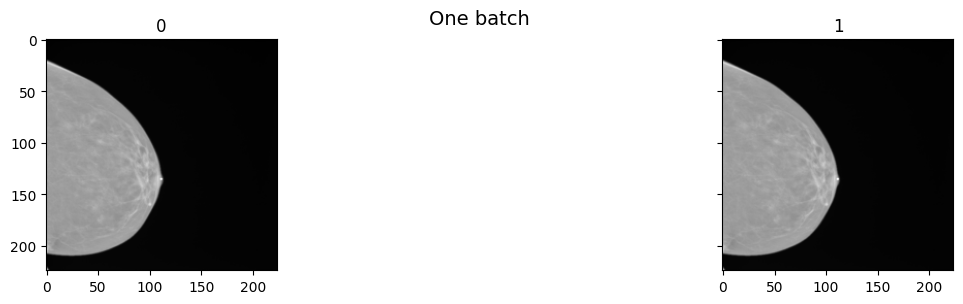

In [14]:
f, axarr = plt.subplots(1, 2, 
                        sharey=True,
                        figsize=(16, 3))
f.suptitle('One batch', fontsize=14)

for index_batch in range(len(inputs)):
    axarr[index_batch].imshow(inputs[index_batch].numpy()[0], cmap='gray')
    axarr[index_batch].set_title(int(classes[index_batch]))

plt.imshow(inputs[0].numpy()[0], cmap='gray')

In [ ]:
out = torchvision.utils.make_grid(inputs)

plt.imshow(out, title=[class_names[x] for x in classes])

# Create Pre-Trained Model

## efficientnet

In [6]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B4_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

simple_transform = transforms.Compose([
    transforms.Resize((300, 300)), 
    transforms.ToTensor(), # between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])



In [20]:
model_efficientNet0 = torchvision.models.efficientnet_b4(weights=True).to(device)

# Freeze all base layers in the "features" section of the model (the feature extractor)
for param in model_efficientNet0.features.parameters():
    param.requires_grad = False

In [21]:
model_efficientNet0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)
DROPOUT_PROB = 0.1

# model_efficientNet0.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p=DROPOUT_PROB, inplace=True), 
#     torch.nn.Linear(in_features=1792, 
#                     out_features=output_shape,
#                     bias=True)
#     ).to(device)

model_efficientNet0.classifier = torch.nn.Linear(in_features=1792, 
                    out_features=output_shape,
                    bias=True
                    ).to(device)


In [23]:
model_efficientNet0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [24]:
summary(
    model=model_efficientNet0, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]  [32, 2]            --                 Partial
├─Sequential (features)                                      [32, 3, 224, 224]  [32, 1792, 7, 7]   --                 False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]  [32, 48, 112, 112] --                 False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]  [32, 48, 112, 112] (1,296)            False
│    │    └─BatchNorm2d (1)                                  [32, 48, 112, 112] [32, 48, 112, 112] (96)               False
│    │    └─SiLU (2)                                         [32, 48, 112, 112] [32, 48, 112, 112] --                 --
│    └─Sequential (1)                                        [32, 48, 112, 112] [32, 24, 112, 112] --                 False
│    

In [25]:
from utils.util_train import *

LR = 0.00001
loss_func = nn.CrossEntropyLoss() # multi-class classification
optimizer = torch.optim.Adam(model_efficientNet0.parameters(), lr=LR)
no_of_epochs = 30

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time_train = time.time()
model_efficientNet0_acc_loss_vals = train(model=model_efficientNet0,
                                        train_dataloader=train_dataloader,
                                        test_dataloader=test_dataloader,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        epochs=no_of_epochs,
                                        device=device,
                                        log_txt_saver=False)

end_time_train = time.time()

print(f"Total training time: {end_time_train-start_time_train:.3f} (s).")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6929 | train_accuracy: 0.5061 | test_loss: 0.6351 | test_accuracy: 0.7236
Epoch: 2 | train_loss: 0.6910 | train_accuracy: 0.5270 | test_loss: 0.6490 | test_accuracy: 0.6659
Epoch: 3 | train_loss: 0.6897 | train_accuracy: 0.5328 | test_loss: 0.6368 | test_accuracy: 0.6947
Epoch: 4 | train_loss: 0.6868 | train_accuracy: 0.5569 | test_loss: 0.6321 | test_accuracy: 0.7019
Epoch: 5 | train_loss: 0.6862 | train_accuracy: 0.5593 | test_loss: 0.6603 | test_accuracy: 0.6406
Epoch: 6 | train_loss: 0.6842 | train_accuracy: 0.5697 | test_loss: 0.6595 | test_accuracy: 0.6442
Epoch: 7 | train_loss: 0.6832 | train_accuracy: 0.5705 | test_loss: 0.6555 | test_accuracy: 0.6719
Epoch: 8 | train_loss: 0.6802 | train_accuracy: 0.5867 | test_loss: 0.6731 | test_accuracy: 0.5853
Epoch: 9 | train_loss: 0.6782 | train_accuracy: 0.5899 | test_loss: 0.6175 | test_accuracy: 0.7548
Epoch: 10 | train_loss: 0.6766 | train_accuracy: 0.6006 | test_loss: 0.6564 | test_accuracy: 0.6310
Epoch: 11

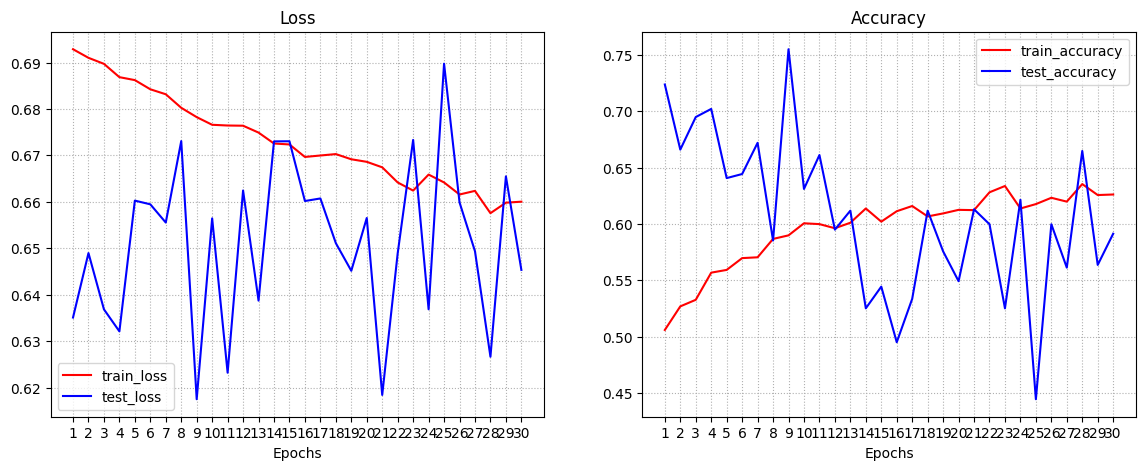

In [26]:
from utils.util_plots2 import *

def plot_loss_accuracy_grid2_v2(results):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    x_ticks_range = 1

    # epochs = range(len(results["train_loss"]))
    epochs = np.arange(1, len(results["train_loss"])+1)

    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, x_ticks_range))
    plt.plot(epochs, train_loss, label="train_loss", color = "red")
    plt.plot(epochs, test_loss, label="test_loss", color = "blue")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True)
    plt.grid(True,linestyle=':')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, x_ticks_range))
    plt.plot(epochs, train_accuracy, label="train_accuracy", color = "red")
    plt.plot(epochs, test_accuracy, label="test_accuracy", color = "blue")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True,linestyle=':')


plot_loss_accuracy_grid2_v2(model_efficientNet0_acc_loss_vals)

## densenet

In [9]:
# Get a set of pretrained model weights
weights = torchvision.models.DenseNet121_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [11]:
# model_resNet0 = torchvision.models.resnet50(weights=True).to(device)
model_resNet0 = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)

# # Freeze all base layers in the "features" section of the model (the feature extractor)
# for param in model_resNet0.features.parameters():
#     param.requires_grad = True

In [12]:
model_resNet0

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# # make input one channel
# model_resNet0.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), 
#                       stride=(2, 2), padding=(3, 3), bias=False)

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)
DROPOUT_PROB = 0.1

model_resNet0.fc = torch.nn.Sequential(
    # torch.nn.Dropout(p=DROPOUT_PROB, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape,
                    bias=True)
    ).to(device)

# model_resNet0.classifier = torch.nn.Linear(in_features=1024, 
#                     out_features=output_shape,
#                     bias=True).to(device)


In [ ]:
summary(
    model=model_resNet0, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
) 

In [14]:
model_resNet0

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
from utils.util_train import *

LR = 0.000001
loss_func = nn.CrossEntropyLoss() # multi-class classification
optimizer = torch.optim.Adam(model_resNet0.parameters(), lr=LR)
no_of_epochs = 20

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time_train = time.time()
model_efficientNet0_acc_loss_vals = train(model=model_resNet0,
                                        train_dataloader=train_dataloader,
                                        test_dataloader=test_dataloader,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        epochs=no_of_epochs,
                                        device=device,
                                        log_txt_saver=False)

end_time_train = time.time()

print(f"Total training time: {end_time_train-start_time_train:.3f} (s).")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.4553 | train_accuracy: 0.1396 | test_loss: 4.7771 | test_accuracy: 0.1736
Epoch: 2 | train_loss: 3.6414 | train_accuracy: 0.4573 | test_loss: 2.5377 | test_accuracy: 0.6108
Epoch: 3 | train_loss: 1.8202 | train_accuracy: 0.6309 | test_loss: 1.2858 | test_accuracy: 0.7137
Epoch: 4 | train_loss: 1.0052 | train_accuracy: 0.6767 | test_loss: 1.1426 | test_accuracy: 0.5712
Epoch: 5 | train_loss: 0.7022 | train_accuracy: 0.7085 | test_loss: 0.6655 | test_accuracy: 0.7551
Epoch: 6 | train_loss: 0.5833 | train_accuracy: 0.7376 | test_loss: 0.6397 | test_accuracy: 0.7072
Epoch: 7 | train_loss: 0.5264 | train_accuracy: 0.7497 | test_loss: 0.7375 | test_accuracy: 0.6257
Epoch: 8 | train_loss: 0.4930 | train_accuracy: 0.7647 | test_loss: 0.7159 | test_accuracy: 0.6257
Epoch: 9 | train_loss: 0.4558 | train_accuracy: 0.7854 | test_loss: 0.6562 | test_accuracy: 0.6550
Epoch: 10 | train_loss: 0.4324 | train_accuracy: 0.7987 | test_loss: 0.6998 | test_accuracy: 0.6364
Epoch: 11

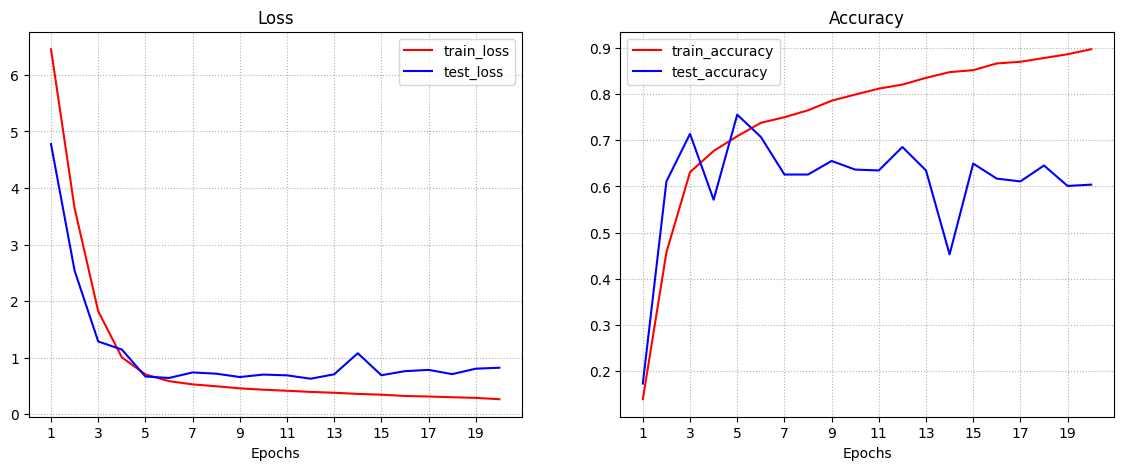

In [16]:
from utils.util_plots2 import *

def plot_loss_accuracy_grid2_v2(results):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    train_accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    x_ticks_range = 2

    # epochs = range(len(results["train_loss"]))
    epochs = np.arange(1, len(results["train_loss"])+1)

    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, x_ticks_range))
    plt.plot(epochs, train_loss, label="train_loss", color = "red")
    plt.plot(epochs, test_loss, label="test_loss", color = "blue")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True)
    plt.grid(True,linestyle=':')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, x_ticks_range))
    plt.plot(epochs, train_accuracy, label="train_accuracy", color = "red")
    plt.plot(epochs, test_accuracy, label="test_accuracy", color = "blue")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid(True,linestyle=':')


plot_loss_accuracy_grid2_v2(model_efficientNet0_acc_loss_vals)

In [26]:
model_efficientNet0_acc_loss_vals["test_acc"]

[0.17364990689013035,
 0.6108007448789572,
 0.7136871508379888,
 0.5712290502793296,
 0.75512104283054,
 0.707169459962756,
 0.6256983240223464,
 0.6256983240223464,
 0.6550279329608939,
 0.6364059590316573,
 0.6345437616387337,
 0.6852886405959032,
 0.6345437616387337,
 0.45297951582867785,
 0.6494413407821229,
 0.616852886405959,
 0.6108007448789572,
 0.6452513966480447,
 0.601024208566108,
 0.6038175046554934]

# Test & Predictions

In [17]:
test_preds = []
model_resNet0.eval()
# model_efficientNet0.eval()

start_time_testset = time.time()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    
    test_logits = model_resNet0(X)
    # test_logits = model_efficientNet0(X)
    pred_probs = torch.softmax(test_logits, dim=1)  # Convert the pred logits to pred probs
    pred_labels = torch.argmax(pred_probs, dim=1)  # Convert the pred probs into pred labels

    test_preds.append(pred_labels) 

end_time_testset = time.time()
print(f"Total testing time: {end_time_testset-start_time_testset:.3f} (s).")

test_preds = torch.cat(test_preds).cpu()
test_truth = torch.cat([y for X, y in test_dataloader])

  0%|          | 0/537 [00:19<?, ?it/s]

Total testing time: 57.130 (s).


In [18]:
# print(test_preds)
print(len(test_preds))

unique, counts = np.unique(test_preds.cpu().detach().numpy(), return_counts=True)
print(dict(zip(unique, counts)))

2148
{0: 1290, 1: 858}


Main Parameters of model:Batch size: 4 
Epochs: 20 
Learning Rate: 1e-06 
Dropout Prob: 0.1 
Training time: 8946.117


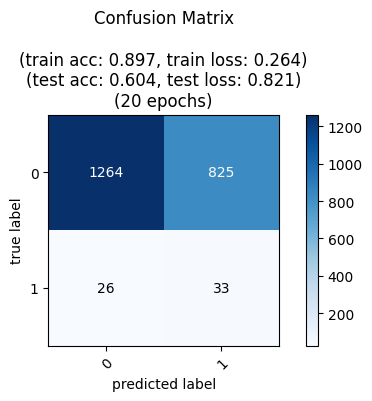

In [19]:
# !pip install -q torchmetrics -U mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix_multiclass = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_matrix_tensor = conf_matrix_multiclass(preds=test_preds, target=test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix_tensor.numpy(), 
    class_names=class_names,
    figsize=(7, 3),
    colorbar=True,
    # cmap = 'magma_r'
)

last_train_acc = round(model_efficientNet0_acc_loss_vals['train_acc'][no_of_epochs-1],3)
last_train_loss = round(model_efficientNet0_acc_loss_vals['train_loss'][no_of_epochs-1],3)
last_test_acc = round(model_efficientNet0_acc_loss_vals['test_acc'][no_of_epochs-1],3)
last_test_loss = round(model_efficientNet0_acc_loss_vals['test_loss'][no_of_epochs-1],3)

ax.set_title(f"Confusion Matrix"
    +f"\n\n"+
    f"(train acc: {last_train_acc}, train loss: {last_train_loss})\n" +
    f"(test acc: {last_test_acc}, test loss: {last_test_loss})\n" +
    f"({no_of_epochs} epochs)"
    )

print(f"Main Parameters of model:"+ 
      f"Batch size: {BATCH_SIZE} \n"+
      f"Epochs: {no_of_epochs} \n"+
      f"Learning Rate: {LR} \n"+
      f"Dropout Prob: {DROPOUT_PROB} \n"+
      f"Training time: {end_time_train-start_time_train:.3f}"
      )

In [20]:
from sklearn.metrics import classification_report
print(classification_report(test_truth, test_preds))

              precision    recall  f1-score   support

           0       0.98      0.61      0.75      2089
           1       0.04      0.56      0.07        59

    accuracy                           0.60      2148
   macro avg       0.51      0.58      0.41      2148
weighted avg       0.95      0.60      0.73      2148



In [21]:
print(test_preds)
print(test_truth)

print(len(test_preds))
print(len(test_truth))

tensor([0, 0, 0,  ..., 0, 1, 1])
tensor([0, 0, 0,  ..., 1, 1, 1])
2148
2148


[0.        0.3949258 1.       ]
[0.         0.55932203 1.        ]
[2 1 0]


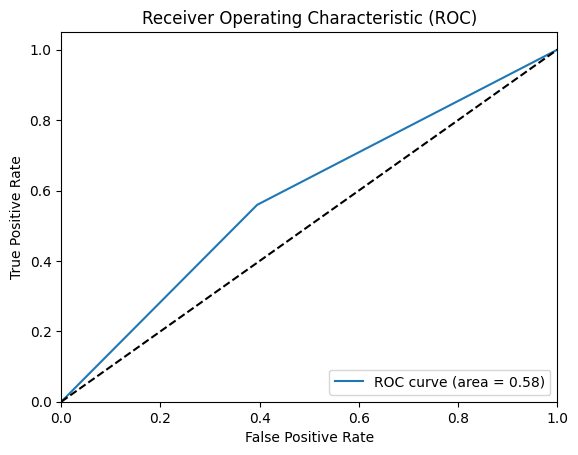

In [27]:
from sklearn.metrics import roc_curve, auc

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y,dropIntOpt):
    fpr, tpr, thresholds = roc_curve(y, pred,drop_intermediate=dropIntOpt)
    roc_auc = auc(fpr, tpr)
    print(fpr)
    print(tpr)
    print(thresholds)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(test_preds,test_truth,False)

# plot_roc(pred_probs,test_truth,False)

In [ ]:
# [0.         0.36106909 1.        ]
# [0.         0.69642857 1.        ]
# [2 1 0]

# Most wrong predictions in the test set

In [28]:
test_data_paths = list(Path(test_dir).glob("*/*.png"))
test_labels = [path.parent.stem for path in test_data_paths]
print(test_data_paths)
print(test_labels)

[WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10102_1181635673.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10102_618254763.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10151_2062101003.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10188_1481469520.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10200_1422756511.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10226_348710745.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/1026_633991369.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/1026_699715160.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10289_1390886438.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10317_428643313.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10335_1152574310.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10468_435970835.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10509_930382814.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10526_880953279.png'), WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10552_1676779

In [29]:
test_data_paths = list(Path(test_dir).glob("*/*.png"))
test_labels = [path.parent.stem for path in test_data_paths]



# with torch.inference_mode():
#   for X, y in tqdm(test_dataloader):
#     X, y = X.to(device), y.to(device)
    
#     test_logits = model_resNet0(X)
#     # test_logits = model_efficientNet0(X)
#     pred_probs = torch.softmax(test_logits, dim=1)  # Convert the pred logits to pred probs
#     pred_labels = torch.argmax(pred_probs, dim=1)  # Convert the pred probs into pred labels

#     test_preds.append(pred_labels) 


# list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    
    pred_dict = {}
    pred_dict["image_path"] = path # get path for selected image
    class_name = path.parent.stem # get parent directory name for selected image
    pred_dict["class_name"] = class_name



    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    
    model.eval()
    
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item() # back on the CPU 
      pred_dict["pred_class"] = pred_class
  
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    test_pred_list.append(pred_dict)

  return test_pred_list

In [30]:
simple_transform2 = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(), # between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [31]:
test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_resNet0,
                                 transform=simple_transform2,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/2148 [00:00<?, ?it/s]

[{'image_path': WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10102_1181635673.png'),
  'class_name': '0',
  'pred_prob': 0.8414755463600159,
  'pred_class': '0',
  'correct': True},
 {'image_path': WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10102_618254763.png'),
  'class_name': '0',
  'pred_prob': 0.8583065867424011,
  'pred_class': '0',
  'correct': True},
 {'image_path': WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10151_2062101003.png'),
  'class_name': '0',
  'pred_prob': 0.6867614984512329,
  'pred_class': '0',
  'correct': True},
 {'image_path': WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10188_1481469520.png'),
  'class_name': '0',
  'pred_prob': 0.9340521097183228,
  'pred_class': '0',
  'correct': True},
 {'image_path': WindowsPath('ds/DARK/aug_49_mlo_CROP/test/0/10200_1422756511.png'),
  'class_name': '0',
  'pred_prob': 0.6078763008117676,
  'pred_class': '0',
  'correct': True}]

In [32]:
test_pred_df = pd.DataFrame(test_pred_dicts)

no_of_disp_wrong_samples = 6
# Sort DF by correct then by pred_prob 
top_most_wrongs = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head(no_of_disp_wrong_samples)
top_most_wrongs

,image_path,class_name,pred_prob,pred_class,correct
913,ds\DARK\aug_49_mlo_CROP\test\0\36245_134062771...,0,0.999819,1,False
1130,ds\DARK\aug_49_mlo_CROP\test\0\41557_189423042...,0,0.998140,1,False
2085,ds\DARK\aug_49_mlo_CROP\test\0\9749_1587184723...,0,0.998103,1,False
2084,ds\DARK\aug_49_mlo_CROP\test\0\9749_1486079471...,0,0.997630,1,False
1514,ds\DARK\aug_49_mlo_CROP\test\0\52363_117379352...,0,0.996598,1,False
103,ds\DARK\aug_49_mlo_CROP\test\0\1349_788034359.png,0,0.996500,1,False


In [33]:
print(len(test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False])))

sorted_test_pred_df = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False])
f = open("worst_preds.txt", "a")


for index, row in sorted_test_pred_df.iterrows():
    row_str = str(row["image_path"])+","+str(row["class_name"])+","+str(row["pred_prob"])+","+str(row["pred_class"])+","+str(row["correct"])
    print(row_str)
    f.write(row_str)
    f.write("\n")

f.close()


2148
ds\DARK\aug_49_mlo_CROP\test\0\36245_1340627711.png,0,0.9998194575309753,1,False
ds\DARK\aug_49_mlo_CROP\test\0\41557_1894230428.png,0,0.9981403350830078,1,False
ds\DARK\aug_49_mlo_CROP\test\0\9749_1587184723.png,0,0.9981030225753784,1,False
ds\DARK\aug_49_mlo_CROP\test\0\9749_1486079471.png,0,0.99763023853302,1,False
ds\DARK\aug_49_mlo_CROP\test\0\52363_1173793528.png,0,0.9965978264808655,1,False
ds\DARK\aug_49_mlo_CROP\test\0\1349_788034359.png,0,0.9965000152587891,1,False
ds\DARK\aug_49_mlo_CROP\test\0\11781_1191431997.png,0,0.9963439106941223,1,False
ds\DARK\aug_49_mlo_CROP\test\0\48396_1424754270.png,0,0.9962652325630188,1,False
ds\DARK\aug_49_mlo_CROP\test\0\35847_150681526.png,0,0.9931185245513916,1,False
ds\DARK\aug_49_mlo_CROP\test\0\41618_687550778.png,0,0.9927775859832764,1,False
ds\DARK\aug_49_mlo_CROP\test\0\16372_1247995608.png,0,0.9925985336303711,1,False
ds\DARK\aug_49_mlo_CROP\test\0\51064_360831180.png,0,0.991211473941803,1,False
ds\DARK\aug_49_mlo_CROP\test\0\23

In [34]:
sorted_test_pred_df.to_csv("worst_preds_MLO_F_index.csv",index=False)

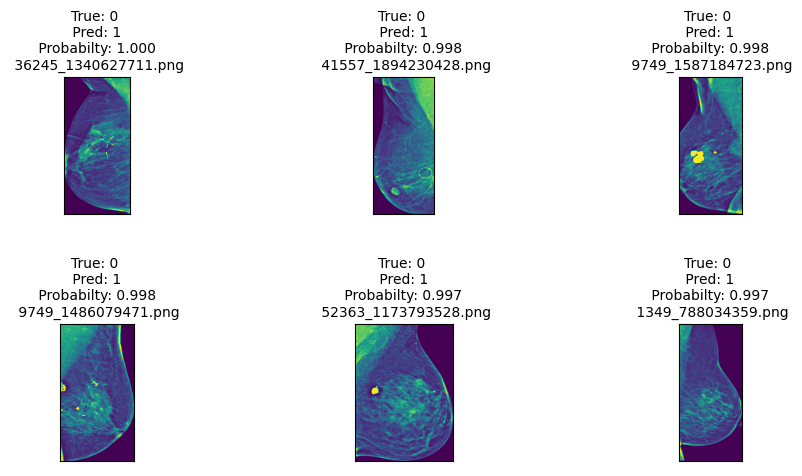

In [49]:
no_of_rows_wrong_plot = 2
no_of_cols_wrong_plot = 3

f, axarr = plt.subplots(no_of_rows_wrong_plot, no_of_cols_wrong_plot)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.4,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.8)
                    

wrong_img_index = 0
for row in range(no_of_rows_wrong_plot):
    for col in range(no_of_cols_wrong_plot):

        image_path = top_most_wrongs.iloc[wrong_img_index]['image_path']
        true_label = top_most_wrongs.iloc[wrong_img_index]['class_name']
        pred_prob = top_most_wrongs.iloc[wrong_img_index]['pred_prob']
        pred_class = top_most_wrongs.iloc[wrong_img_index]['pred_class']
        img_path = str(top_most_wrongs.iloc[wrong_img_index]['image_path']).split('\\')[5]
        
        wrong_img_tensor = torchvision.io.read_image(str(image_path)) # get image as tensor

        axarr[row, col].imshow(wrong_img_tensor.permute(1, 2, 0))
        axarr[row, col].set_title(fontsize=10, 
                                  label=f"True: {true_label} \n Pred: {pred_class} \n Probabilty: {pred_prob:.3f} \n {img_path}"
                                  ) 

        wrong_img_index +=1

        axarr[row, col].get_xaxis().set_visible(False)
        axarr[row, col].get_yaxis().set_visible(False)

In [ ]:
test_pred_df = pd.DataFrame(test_pred_dicts)

no_of_disp_wrong_samples = 6
# Sort DF by correct then by pred_prob 
top_most_wrongs = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head(no_of_disp_wrong_samples)
top_most_wrongs

# Single Image Prediction

In [22]:
simple_transform2 = transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [23]:
def pred_single_img(image_path, model, transform, class_names, device=device):
  image = Image.open(image_path)
  transformed_image = transform(image)
  print(transformed_image.shape)

  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
    pred_class = class_names[pred_label.cpu()]
  
  pred_prob_squeezed = pred_prob.unsqueeze(0).max().cpu().item()
  # plot image and pred
  plt.imshow(image,'gray')
  plt.title(f"Pred: {pred_class} \n"+ 
            f"Probabilty: {pred_prob_squeezed:.3f} \n"+
            f"(h: {image.height}, w: {image.width})",
            fontsize=18)
            
  plt.axis(False); 

  print(image)
  print("img width:", image.width, 
          "\nimg height:", image.height)
  

torch.Size([3, 224, 224])
<PIL.PngImagePlugin.PngImageFile image mode=L size=512x512 at 0x2A99EE53D00>
img width: 512 
img height: 512


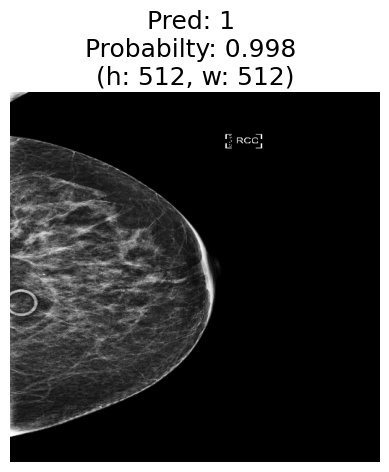

In [25]:
single_img_path_name = "view_dset_01_splitted_aug/cc_splitted/test/1/33971_1445458891.png"

pred_single_img(image_path=single_img_path_name,
              model=model_resNet0,
              transform=simple_transform2,
              class_names=class_names)